<a href="https://colab.research.google.com/github/ayushjain1144/Active-Learning/blob/master/Stream-based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install modAL

In [0]:
import numpy as np
from sklearn import datasets
from sklearn import decomposition

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from modAL.uncertainty import uncertainty_sampling
from modAL.uncertainty import classifier_uncertainty
from modAL.models import ActiveLearner


### Set random seed for uniformity

In [0]:
rnd_seed = 452
np.random.seed(rnd_seed)

### Dataset and its preprocessing

In [0]:
irs = datasets.load_iris()
x_pre = irs['data']
y_pre = irs['target']

In [0]:
pca = decomposition.PCA(n_components=2, random_state=rnd_seed)
irs_trns = pca.fit_transform(X=x_pre)

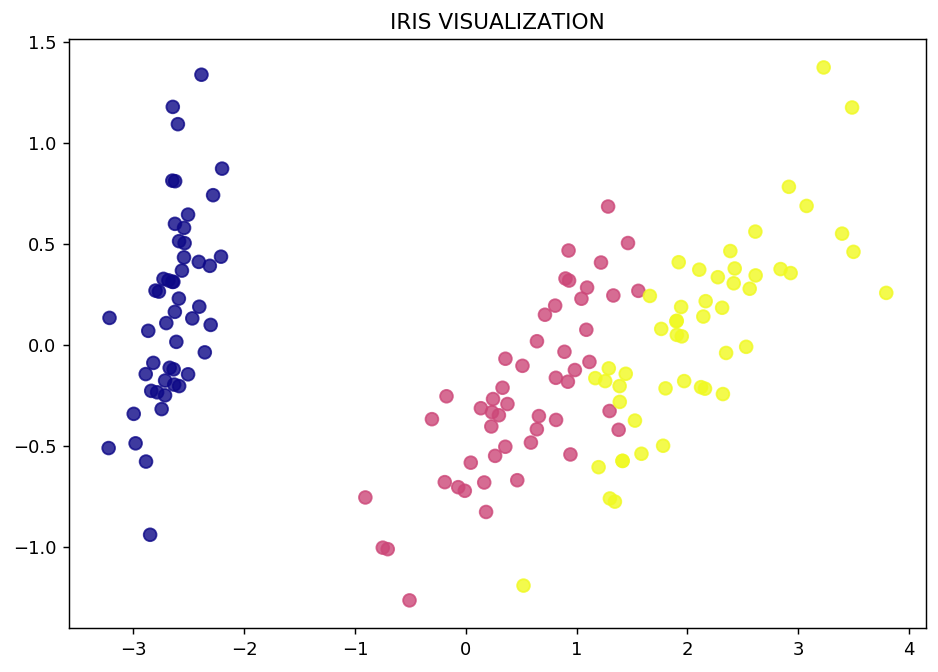

In [0]:
x_c, y_c = irs_trns[:,0], irs_trns[:,1]

plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_c, y=y_c, c=y_pre, cmap='plasma', s=50, alpha=8/10)
plt.title('IRIS VISUALIZATION')
plt.show()

In [0]:
dataset_size = x_pre.shape

### 3 points randomly selected as initial dataset

In [0]:
idx_training = np.random.randint(low=0,high=dataset_size[0], size=3)
x_train = x_pre[idx_training]
y_train = y_pre[idx_training]

x_pool = np.delete(x_pre, idx_training, axis=0)

y_pool = np.delete(y_pre, idx_training, axis=0)

In [0]:
knn = KNeighborsClassifier(n_neighbors=3)

learner = ActiveLearner(estimator=knn, query_strategy=uncertainty_sampling, X_training=x_train, y_training=y_train)
initial_score = learner.score(x_pool, y_pool)

print(f"Prediction Accuracy using only 3 samples - KNN: {initial_score}")

Prediction Accuracy using only 3 samples - KNN: 0.3333333333333333


In [0]:
# Evaluating the model's performance on the initial dataset

pred_initial = learner.predict(x_pre)
is_correct_pred = (pred_initial == y_pre)

pred_initial

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

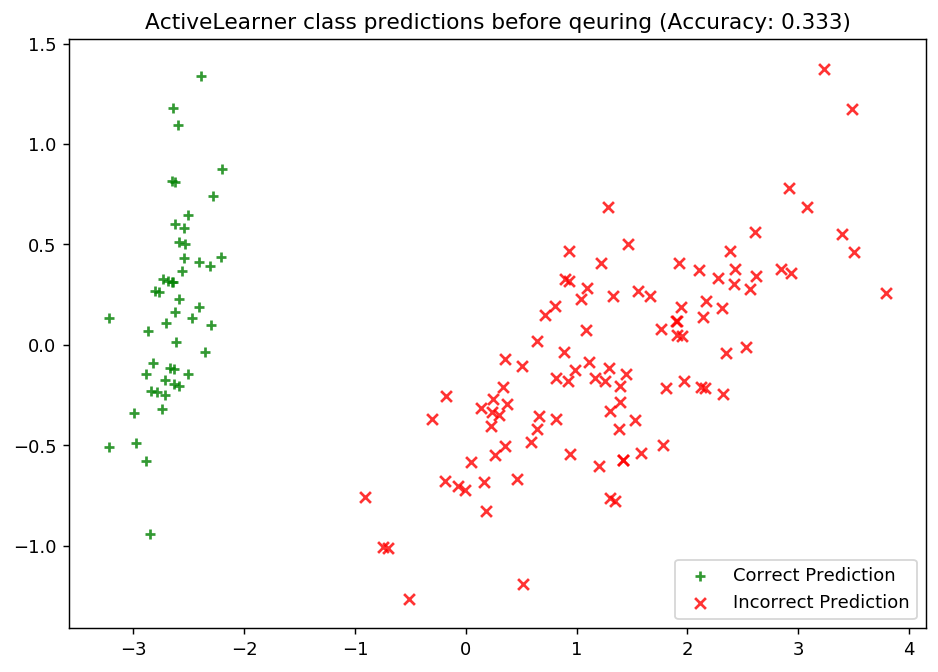

In [0]:

score_before_querying = learner.score(x_pre, y_pre)

# Plot the results

fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_c[is_correct_pred],  y=y_c[is_correct_pred],  c='g', marker='+', label='Correct Prediction',   alpha=8/10)
ax.scatter(x=x_c[~is_correct_pred], y=y_c[~is_correct_pred], c='r', marker='x', label='Incorrect Prediction', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions before qeuring (Accuracy: {score:.3f})".format(score=score_before_querying))
plt.show()

### Accuracy achieved after training on whole dataset

In [0]:
learner_full = ActiveLearner(estimator=knn, query_strategy=uncertainty_sampling, X_training=x_pre, y_training=y_pre)
score_full = learner_full.score(x_pre, y_pre)

print(f"Prediction Accuracy using whole dataset - KNN: {score}")

Prediction Accuracy using whole dataset - KNN: 0.96


In [0]:
knn = KNeighborsClassifier(n_neighbors=3)

learner = ActiveLearner(estimator=knn, query_strategy=uncertainty_sampling, X_training=x_train, y_training=y_train)
initial_score = learner.score(x_pool, y_pool)

print(f"Prediction Accuracy using only 3 samples - KNN: {initial_score}")

Prediction Accuracy using only 3 samples - KNN: 0.3333333333333333


In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:

# learner = ActiveLearner(estimator= RandomForestClassifier(), query_strategy=uncertainty_sampling, X_training=x_train, y_training=y_train)
# initial_score = learner.score(x_pool, y_pool)

# print(f"Prediction Accuracy using only 3 samples - RandomForestClassifier: {initial_score}")

In [0]:
from modAL.uncertainty import classifier_uncertainty

accuracy_list = []
num_queried = 0
num_ignored = 0

while learner.score(x_pre, y_pre) < 0.95:

  #choose a point randomly to check - simulate a stream

  point = np.random.choice(range(len(x_pre)))
  if classifier_uncertainty(learner, x_pre[point].reshape(1, -1)) >= 0.3:

    #learning again after every query; might avoid it if the trainnig is time consuming
    learner.teach(x_pre[point].reshape(1, -1), y_pre[point].reshape(-1, ))
    updated_acc = learner.score(x_pre, y_pre)
    accuracy_list.append(updated_acc)
    num_queried += 1
    print(f"Point updated: {point}; Accuracy achieved: {updated_acc}")

  else:
    num_ignored += 1
    print(f"Ignored this point from labelling: {point}") 

print(f"Final Accuracy: {accuracy_list[-1]}, Queries sent to oracle: {num_queried}, Points Ignored: {num_ignored}")

Point updated: 87; Accuracy achieved: 0.3333333333333333
Point updated: 10; Accuracy achieved: 0.6666666666666666
Point updated: 71; Accuracy achieved: 0.6666666666666666
Point updated: 25; Accuracy achieved: 0.6666666666666666
Point updated: 72; Accuracy achieved: 0.6666666666666666
Point updated: 123; Accuracy achieved: 0.9266666666666666
Point updated: 107; Accuracy achieved: 0.9266666666666666
Ignored this point from labelling: 100
Point updated: 113; Accuracy achieved: 0.9266666666666666
Point updated: 128; Accuracy achieved: 0.9266666666666666
Ignored this point from labelling: 34
Ignored this point from labelling: 21
Ignored this point from labelling: 62
Ignored this point from labelling: 42
Point updated: 98; Accuracy achieved: 0.9266666666666666
Ignored this point from labelling: 26
Ignored this point from labelling: 70
Ignored this point from labelling: 24
Ignored this point from labelling: 18
Ignored this point from labelling: 29
Point updated: 91; Accuracy achieved: 0.93333

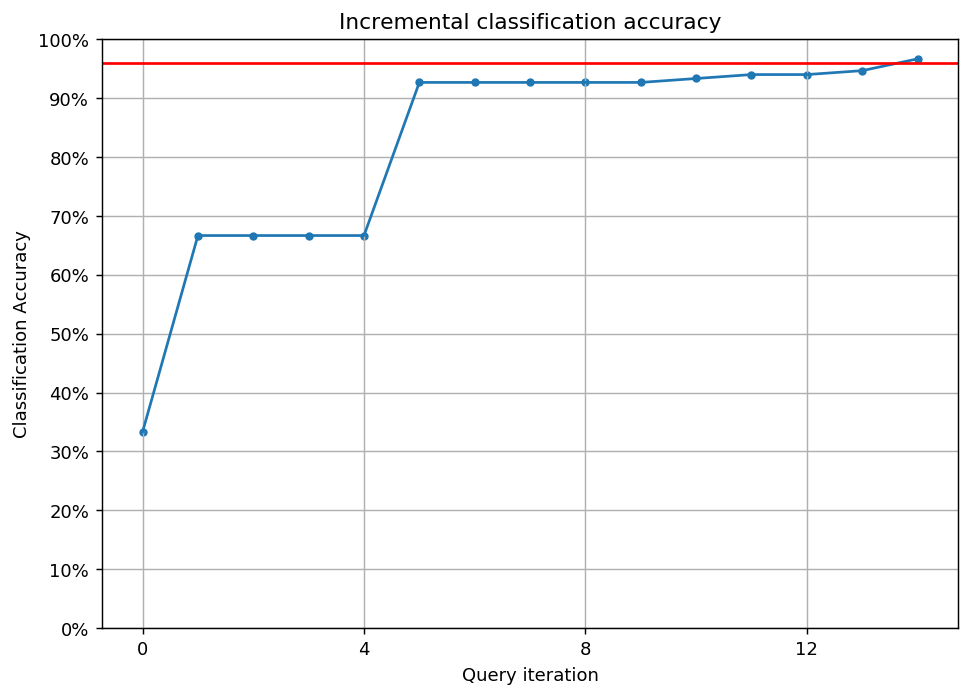

In [0]:
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(accuracy_list)
ax.scatter(range(len(accuracy_list)), accuracy_list, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

plt.axhline(y=score_full, color = 'red')

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

### As we can see, Active Learning performed even better on the dataset than the case where we were using more training data

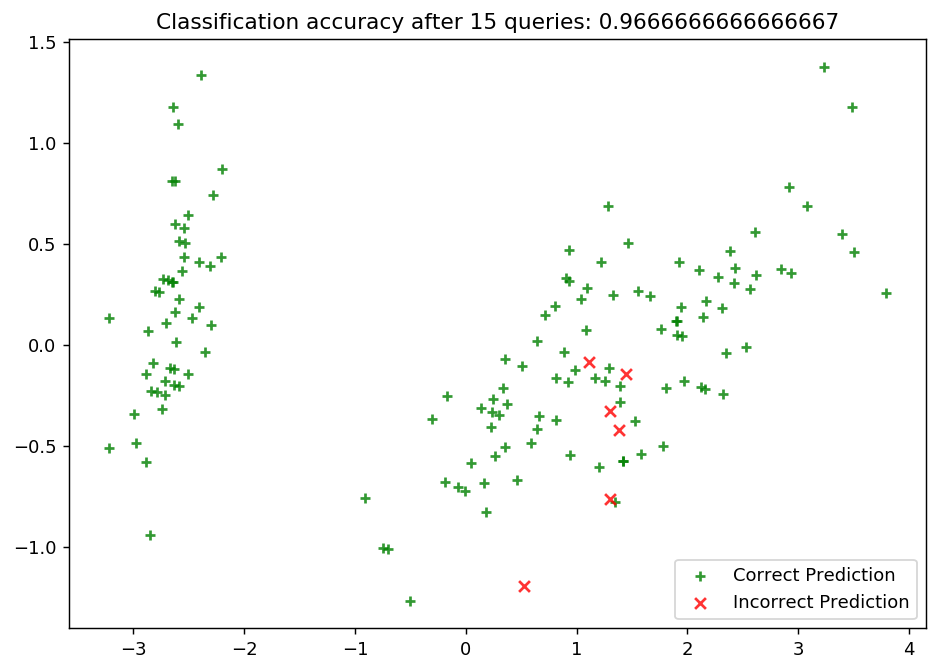

In [0]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(x_pre)
is_correct = (predictions == y_pre)


# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_c[is_correct],  y=y_c[is_correct],  c='g', marker='+', label='Correct Prediction',   alpha=8/10)
ax.scatter(x=x_c[~is_correct], y=y_c[~is_correct], c='r', marker='x', label='Incorrect Prediction', alpha=8/10)

ax.set_title(f'Classification accuracy after {num_queried} queries: {accuracy_list[-1]}')
ax.legend(loc='lower right')

plt.show()